In [131]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import torchvision.utils as vutils

import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [132]:
lr = 0.001
BATCH_SIZE = 512
epochs = 10
num_classes = 10
latent_size = 128 # Size of the latent vector

In [133]:
transform = transforms.Compose([transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])

train_data = Datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = Datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE)

### Encoder

**In a VAE, the encoder takes an input and produces two outputs for each latent variable: a mean, $\mu$, and a standard deviation, $\sigma$.** These parameters define a Gaussian distribution for each dimension in the latent space.

To sample from this distribution while still allowing gradient descent, VAE use the **reparameterization trick.** This trick expresses a random sample $z$ as:

$$
z = \mu + \sigma \times \epsilon
$$

Where:

- $\mu$ is the mean of the distribution
- $\sigma$ is the standard deviation of the distribution
- $\epsilon$ is drawn from the distribution.

### Decoder

The decoder takes the sampled latent vector, $z$, and reconstructs the input similar to a regular AutoEncoder. It learns to generate data that is similar to the original input, effectively learning the data’s underlying distribution.

### KL Divergence Loss

KL Divergence Loss quantifies how one probability distribution diverges from a second, reference probability distribution.

The KL Divergence between two normal distributions where:

$$
p(x)=N(\mu_p,\sigma_p)
$$

$$
q(x)=N(\mu_q,\sigma_q)
$$

is:

$$
KL(p, q)=ln(\frac{\sigma_q}{\sigma_q})+\frac{\sigma^2_p+(\mu_p-\mu_q)^2}{2 \sigma^2_p}-\frac{1}{2}
$$

**Using the encoder, we produce a $\sigma$ and $\mu$ per dimension and sample from a gaussian distribution once per dimension witht he given $\sigma$ and $\mu$. We then pass the sampled vector to the decoder which will try and reconstruct the original image.**

The KL loss tries to force the distribution from the encoder to be that of a unit gaussian where $\sigma = 1$ and $\mu = 0$ (also known as a Standard Normal Distribution).

To do this, we create a loss using the KL Divergence (a value that is always positive) between the distribution produced by the encoder and that of a unit gaussian.

So the above becomes:

$$
p(x)=N(\mu_p,\sigma_p)
$$

$$
q(x)=N(0, 1)
$$

$$
KL(p, q)= -\frac{1}{2} (2 \cdot ln(\sigma_p) - \sigma_p^2 - \mu^2_p + 1)
$$

We can use this loss function to minimize the loss by bringing our distribution closer to a unit gaussian.

In [134]:
def vae_loss(recon, x, mu, log_var):
  recon_loss = F.mse_loss(recon, x)

  # KL Divergence Loss
  # We will use the mean across the dimensions instead of the sum
  kl_loss = -0.5 * (1 + log_var - mu.pow(2) - log_var.exp()).mean()

  # Tune the strength of KL divergance loss
  loss = recon_loss + 0.1 * kl_loss
  return loss

In [135]:
class EncoderBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int):
    super().__init__()
    self.conv_1 = nn.Conv2d(in_channels=in_channels,
                           out_channels=out_channels,
                           kernel_size=3,
                           stride=2,
                           padding=1)
    self.batch_norm_1 = nn.BatchNorm2d(out_channels)

    self.skip_conv = nn.Conv2d(in_channels=in_channels,
                           out_channels=out_channels,
                           kernel_size=3,
                           stride=2,
                           padding=1)

    self.conv_2 = nn.Conv2d(in_channels=out_channels,
                           out_channels=out_channels,
                           kernel_size=3,
                           stride=1,
                           padding=1)
    self.batch_norm_2 = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    x_skip = self.skip_conv(x)

    x = F.elu(self.batch_norm_1(self.conv_1(x)))
    x = self.conv_2(x) + x_skip

    return F.elu(self.batch_norm_2(x))

class DecoderBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int):
    super().__init__()

    self.batch_norm_1 = nn.BatchNorm2d(in_channels)
    self.conv_1 = nn.Conv2d(in_channels=in_channels,
                            out_channels=in_channels,
                            kernel_size=3,
                            stride=1,
                            padding=1)

    self.skip_conv = nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=3,
                            stride=1,
                            padding=1)

    self.batch_norm_2 = nn.BatchNorm2d(in_channels)
    self.conv_2 = nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=3,
                            stride=1,
                            padding=1)

    self.upscale = nn.Upsample(scale_factor=2, mode="nearest")

  def forward(self, x):
    x = F.elu(self.batch_norm_1(x))

    x_skip = self.upscale(self.skip_conv(x))

    x = self.upscale(F.elu(self.batch_norm_2(self.conv_1(x))))
    return self.conv_2(x) + x_skip

In [136]:
class Encoder(nn.Module):
  def __init__(self,
               in_channels: int,
               out_channels: int = 32,
               latent_size: int = 32):
    super().__init__()
    self.conv_in = nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=3,
                            stride=1,
                            padding=1)

    self.conv_block_1 = EncoderBlock(in_channels=out_channels, out_channels=out_channels)
    self.conv_block_2 = EncoderBlock(in_channels=out_channels, out_channels=(out_channels * 2))
    self.conv_block_3 = EncoderBlock(in_channels=(out_channels * 2), out_channels=(out_channels * 4))

    # Instead of flattening (and then having to unflatten) out our feature map and putting it through a linear layer, we can use a conv layer
    self.conv_mu = nn.Conv2d(in_channels=(out_channels * 4),
                             out_channels=latent_size,
                             kernel_size=4,
                             stride=1)
    self.conv_log_var = nn.Conv2d(in_channels=(out_channels * 4),
                                  out_channels=latent_size,
                                  kernel_size=4,
                                  stride=1)

  def sample(self, mu, log_var):
    std = torch.exp(0.5 * log_var) # Get the standard deviation
    eps = torch.randn_like(std)
    return mu + eps * std # reparameterization trick

  def forward(self, x):
    x = F.elu(self.conv_in(x))

    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.conv_block_3(x)

    mu = self.conv_mu(x)
    log_var = self.conv_log_var(x)
    x = self.sample(mu, log_var) # Get the latent representation using the reparameterization trick

    return x, mu, log_var

class Decoder(nn.Module):
  def __init__(self,
                in_channels: int,
                out_channels: int = 32,
                latent_size: int = 32):
    super().__init__()

    self.conv_in = nn.ConvTranspose2d(in_channels=latent_size,
                                      out_channels=(4 * out_channels),
                                      kernel_size=4,
                                      stride=1)

    self.conv_block_1 = DecoderBlock(in_channels=(4 * out_channels), out_channels=(2 * out_channels))
    self.conv_block_2 = DecoderBlock(in_channels=(2 * out_channels), out_channels=out_channels)
    self.conv_block_3 = DecoderBlock(in_channels=out_channels, out_channels=out_channels)

    self.conv_out = nn.Conv2d(in_channels=out_channels,
                              out_channels=in_channels,
                              kernel_size=3,
                              stride=1,
                              padding=1)

  def forward(self, x):
    x = self.conv_in(x)

    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = F.elu(self.conv_block_3(x))

    return torch.tanh(self.conv_out(x))

In [137]:
class VAE(nn.Module):
  def __init__(self,
               in_channels: int,
               out_channels: int = 16,
               latent_size: int = 32):
    super().__init__()

    self.encoder = Encoder(in_channels=in_channels, out_channels=out_channels, latent_size=latent_size)
    self.decoder = Decoder(in_channels=in_channels, out_channels=out_channels, latent_size=latent_size)

  def forward(self, x):
    encoding, mu, log_var = self.encoder(x)

    # Only sample during training or when we want to generate new images, just use the mean otherwise
    if self.training:
      x = self.decoder(encoding)
    else:
      x = self.decoder(mu)

    return x, mu, log_var

In [138]:
test_images = next(iter(test_dataloader))[0]
test_images.shape #(batch_size, 1, H, W)

torch.Size([512, 1, 32, 32])

(-0.5, 273.5, 35.5, -0.5)

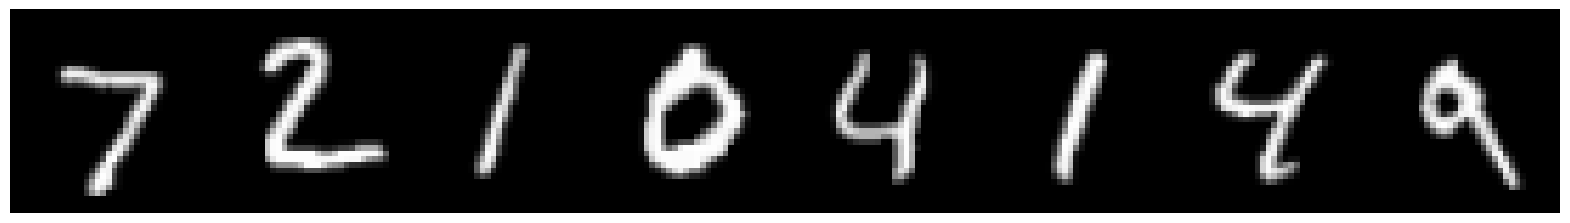

In [139]:
plt.figure(figsize=(20, 10))

out = vutils.make_grid(test_images[:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis(False)

In [140]:
test_images.min(), test_images.max()

(tensor(-1.), tensor(1.))

In [141]:
model = VAE(in_channels=1, out_channels=16, latent_size=latent_size).to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=1e-5, betas=(0.5, 0.999))

In [142]:
recon_data, mu, log_var = model(test_images.to(device))
print(recon_data.shape, mu.shape, log_var.shape)

torch.Size([512, 1, 32, 32]) torch.Size([512, 128, 1, 1]) torch.Size([512, 128, 1, 1])


In [143]:
model_path = "vae_model.pt"
pbar = trange(0, epochs, leave=False, desc="Epoch")

model.train()

for epoch in pbar:
  train_loss = 0

  for i, (image, label) in enumerate(tqdm(train_dataloader, leave=False, desc="Training")):
    image = image.to(device)

    # Reconstructed image data, mean of latent vector, log variance of latent vector
    recon_data, mu, log_var = model(image)

    # Calculate the KL Divergence Loss
    loss = vae_loss(recon_data, image, mu, log_var)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch + 1} | Loss: {train_loss / len(train_dataloader)}")
  pbar.set_postfix_str(f"Loss: {train_loss / len(train_dataloader)}")

  torch.save(model.state_dict(), model_path)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 1 | Loss: 0.14461649733327203


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 2 | Loss: 0.08156368976174774


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 3 | Loss: 0.06958966317065692


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 4 | Loss: 0.06436467372764976


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 5 | Loss: 0.06144637229331469


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 6 | Loss: 0.05951090826321456


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 7 | Loss: 0.05791981477227252


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 8 | Loss: 0.05705856014106233


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 9 | Loss: 0.05559361422971144


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 10 | Loss: 0.05528342850127463


In [144]:
# Predictions

model.eval()
with torch.inference_mode():
  recon_data, mu, log_var = model(test_images.to(device))

(-0.5, 273.5, 35.5, -0.5)

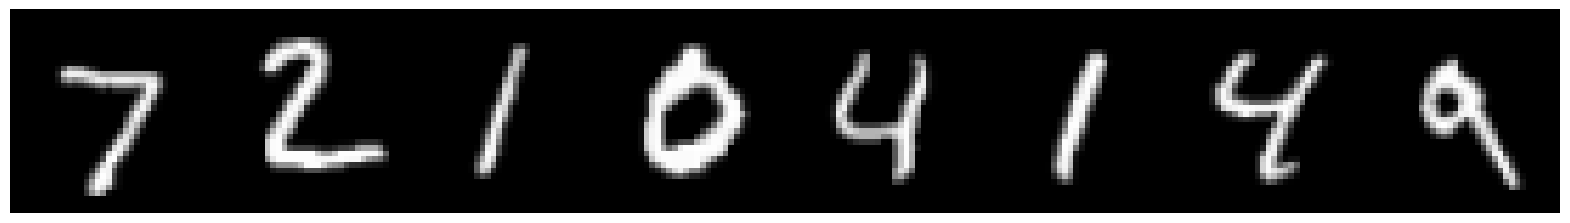

In [145]:
# Ground Truth

plt.figure(figsize=(20, 10))
out = vutils.make_grid(test_images[:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis(False)

(-0.5, 273.5, 35.5, -0.5)

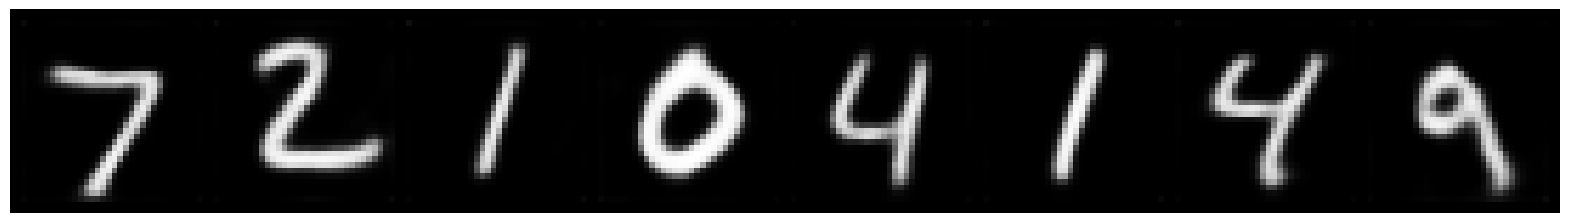

In [146]:
# Reconstruction

plt.figure(figsize=(20, 10))
out = vutils.make_grid(recon_data.detach().cpu()[:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis(False)

(-0.5, 273.5, 35.5, -0.5)

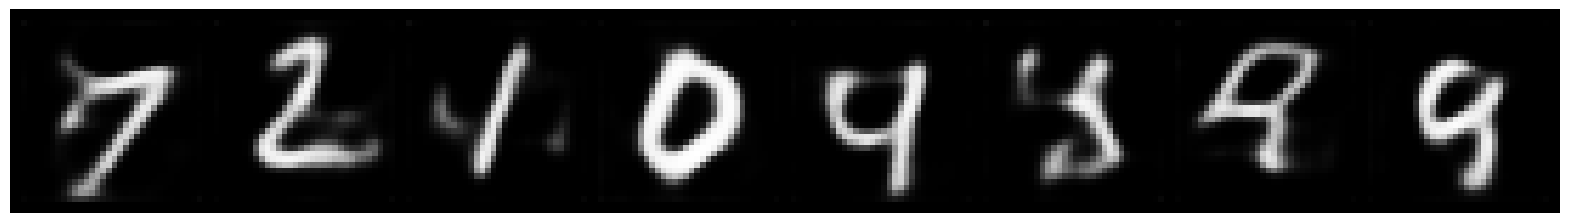

In [147]:
# Random Permutations

rand_samp = model.decoder(mu + 1 * torch.randn_like(mu))
plt.figure(figsize=(20, 10))
out = vutils.make_grid(rand_samp.detach().cpu()[:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis(False)

(-0.5, 273.5, 35.5, -0.5)

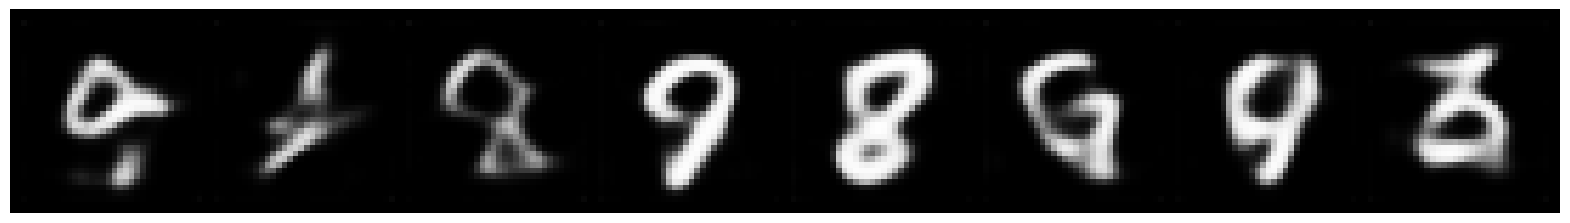

In [148]:
# Random Permutations

rand_samp = model.decoder(torch.randn_like(mu))
plt.figure(figsize=(20, 10))
out = vutils.make_grid(rand_samp.detach().cpu()[:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis(False)